# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [905]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

In [906]:
df = pd.read_csv('data/user-item-interactions.csv')
del df['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [907]:
df_content = pd.read_csv('data/articles_community.csv')
del df_content['Unnamed: 0']

# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [908]:
# understand the user article interaction data
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [909]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [910]:
# convert article id to strings
df.loc[:,'article_id'] = df.loc[:,'article_id'].astype(str)

In [911]:
# some articles don't have an email?
df[df.email.isna()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


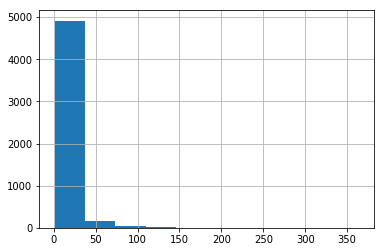

In [912]:
# how users have viewed articles
df.email.value_counts().hist();

In [913]:
# median number of articles that a give user has read
df.email.value_counts().median()

3.0

In [914]:
df.email.value_counts().nlargest(3)

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
Name: email, dtype: int64

In [915]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [916]:
# Find and explore duplicate articles
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


In [917]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [918]:
# convert article id to strings
df_content.loc[:,'article_id'] = df_content.loc[:,'article_id'].astype(float).astype(str)

In [919]:
# looking for unique articles
df_content.article_id.unique().shape

(1051,)

In [920]:
df_content[df_content.duplicated(subset='article_id', keep=False)].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221.0
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221.0
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50.0
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50.0
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0


In [921]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)
df_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1037 non-null object
doc_description    1048 non-null object
doc_full_name      1051 non-null object
doc_status         1051 non-null object
article_id         1051 non-null object
dtypes: object(5)
memory usage: 49.3+ KB


In [922]:
# docs with empty description
df_content[df_content.doc_description.isna()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
354,The search index lets you create flexible quer...,NaN,Build the search index in Cloudant,Live,354.0
768,Compose The Compose logo Articles Sign in Free...,NaN,Announcing the Data Browser for JanusGraph,Live,765.0
919,Cloudant Query is a powerful declarative JSON ...,NaN,Use the new Cloudant query,Live,916.0


In [923]:
# docs with empty body
df_content[df_content.doc_body.isna()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
206,NaN,Watch how to convert XML data to CSV format to...,Load XML data into dashDB,Live,206.0
276,NaN,Love to work in Microsoft Excel? Watch how to ...,Integrate dashDB with Excel,Live,276.0
484,NaN,See how to evaluate and convert your DDL and S...,Convert IBM Puredata for Analytics to dashDB,Live,483.0
508,NaN,Watch how to generate SQL-based reports for Cl...,Use dashDB with IBM Embeddable Reporting Service,Live,507.0
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539.0
638,NaN,See how to create a new dashDB instance and po...,Load JSON from Cloudant database into dashDB,Live,637.0
667,NaN,"See how to connect dashDB, as a source and tar...",Integrate dashDB and Informatica Cloud,Live,666.0
706,NaN,Aginity Workbench is a free application known ...,Use Aginity Workbench for IBM dashDB,Live,704.0
842,NaN,Learn how to configure a dashDB connection in ...,Leverage dashDB in Cognos Business Intelligence,Live,839.0
876,NaN,See how to populate data into a table in your ...,Load data from the desktop into dashDB,Live,873.0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [924]:
# unique articles that have had any interaction
df.article_id.unique().shape

(714,)

In [925]:
# total articles
df_content.article_id.unique().shape

(1051,)

In [926]:
# total unique users
df[~df.email.isna()].email.unique().shape

(5148,)

In [927]:
# total number of interactions
df.shape

(45993, 3)

In [928]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [929]:
# number of times an article is present in views
df.article_id.value_counts().nlargest(3)

1429.0    937
1330.0    927
1431.0    671
Name: article_id, dtype: int64

In [930]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [931]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [932]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [933]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [936]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    ids = get_top_article_ids(n, df)
    top_articles = df[df['article_id'].isin(ids)].title.unique().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.article_id.value_counts().nlargest(n).index.values
 
    return top_articles # Return the top article ids

In [1457]:
get_top_articles(5)

['use deep learning for image classification',
 'predicting churn with the spss random tree algorithm',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'insights from new york car accident reports']

In [940]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [941]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [942]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    users = np.array(df.user_id.unique())
    articles = np.array(df.article_id.unique())

    n_users = len(users)
    n_articles = len(articles)
    
    zero_matrix = np.zeros((n_users, n_articles))
    user_item = pd.DataFrame(data=zero_matrix, index=users, columns=articles)
    
    # Fill in the function here
    for u in users:
        # get the articles that the user has viewed
        user_articles = df[df.user_id == u].article_id.unique()
        for a in user_articles:
            user_item.loc[u,a] = 1
                        
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.shape

(5149, 714)

In [943]:
df[df.user_id == df.iloc[0].user_id].article_id.unique().size

36

In [944]:
user_item.head()

,1430.0,1314.0,1429.0,1338.0,1276.0,1432.0,593.0,1185.0,993.0,14.0,...,1135.0,881.0,183.0,655.0,1233.0,1156.0,555.0,708.0,575.0,972.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [945]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [946]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of similar users and the corresponding similarity
    
    '''
    user_row = user_item.loc[user_id].tolist()
    similar_users = []

    # compute similarity of each user to the provided user
    for _, row in user_item.iterrows():
        res = np.dot(user_row, row.tolist())
        similar_users.append(res)
        
    # create as a dataframe for better handling and remove self row
    similar_df = pd.DataFrame(data=similar_users, index=user_item.index, columns=['similarity'])
    similar_df.drop(index=user_id, inplace=True)
    
    # sort by similarity
    similar_df.sort_values(by='similarity', ascending=False, inplace=True)

    # create list of just the ids
    most_similar_users = similar_df.index.tolist()
    similarity = similar_df.similarity.tolist()
   
    # remove the own user's id
       
    return most_similar_users, similarity # return a list of the users in order from most to least similar
        

In [947]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[0][:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[0][:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[0][:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [948]:
np.dot(user_item.loc[1].to_numpy(), user_item.loc[46].to_numpy())

13.0

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [949]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [950]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


In [954]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    for art in article_ids: # looping so that we can return titles in same order as ids
        article_names.append(df[df['article_id'] == art].iloc[0].title)

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.columns[user_item.loc[user_id] == 1].unique().tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def get_top_user_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    ranked according to the number of interactions each article has had
    
    '''
    # Your code here
    user_article_ids = user_item.columns[user_item.loc[user_id] == 1].unique()
    
    article_ids = df[df['article_id'].isin(user_article_ids)] \
        .groupby(['article_id']).count() \
        .sort_values('title', ascending=False) \
        .reset_index().article_id.tolist()
        
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users = find_similar_users(user_id)[0]
    user_articles, _ = get_user_articles(user_id)

    recs = []
    for u in similar_users:
        sim_articles, _ = get_user_articles(u)
        # remove all the titles that the user has already seen
        sim_articles = np.setdiff1d(sim_articles, user_articles, assume_unique=True)
        # remove all the titles that have been already recommended
        sim_articles = np.setdiff1d(sim_articles, recs, assume_unique=True)
        
        recs.extend(sim_articles)
        
        # stop if we have more than the required recommendations
        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [961]:
# Check Results
get_article_names(user_user_recs(2, 10)) # Return 10 recommendations for user 1

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'use deep learning for image classification',
 'deploy your python model as a restful api',
 'visualize data with the matplotlib library',
 'classify tumors with machine learning',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'apache spark lab, part 1: basic concepts',
 'timeseries data analysis of iot events by using jupyter notebook',
 '10 must attend data science, ml and ai conferences in 2018',
 'the nurse assignment problem']

In [1459]:
get_top_user_articles(2)

(['1427.0', '1314.0', '1305.0', '1176.0', '1422.0', '1024.0'],
 ['use xgboost, scikit-learn & ibm watson machine learning apis',
  'healthcare python streaming application demo',
  'gosales transactions for naive bayes model',
  'build a python app on the streaming analytics service',
  'use r dataframes & ibm watson natural language understanding',
  'using deep learning to reconstruct high-resolution audio'])

In [957]:
df[df['title'] == 'use xgboost, scikit-learn & ibm watson machine learning apis'].article_id.unique()

array(['1427.0'], dtype=object)

In [962]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [965]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    sim_users, similarity = find_similar_users(user_id, user_item)
    article_count = []
    for u in sim_users:
        article_count.append(
            user_item.columns[user_item.loc[u] == 1].unique().size)
    
    neighbors_df = pd.DataFrame(
        data={
            'neighbor_id': sim_users,
            'similarity': similarity, 
            'num_interactions': article_count
        })
    
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    top_users = get_top_sorted_users(user_id)
    user_articles, _ = get_user_articles(user_id)
    
    recs = []
    for _, row in top_users.iterrows():        
        sim_articles, _ = get_top_user_articles(row['neighbor_id'])
        # remove all the titles that the user has already seen
        sim_articles = np.setdiff1d(sim_articles, user_articles, assume_unique=True)
        # remove all the titles that have been already recommended
        sim_articles = np.setdiff1d(sim_articles, recs, assume_unique=True)
        
        recs.extend(sim_articles)
        
        # stop if we have more than the required recommendations
        if len(recs) >= m:
            break    
    
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [1461]:
# checking functions
get_top_sorted_users(1)[0:20]

,neighbor_id,similarity,num_interactions
0,3933,35.0,35
1,23,17.0,135
2,3782,17.0,135
3,203,15.0,96
4,4459,15.0,96
5,3870,14.0,75
6,131,14.0,75
7,46,13.0,40
8,4201,13.0,40
11,49,12.0,101


In [967]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'putting a human face on machine learning', 'gosales transactions for naive bayes model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [968]:
get_top_sorted_users(1).iloc[0].neighbor_id

3933.0

In [969]:
get_top_sorted_users(131).iloc[0:11].neighbor_id

0     3870
1     3782
2       23
3      203
4     4459
5       49
7     3697
6     3764
8       98
9     3910
10     242
Name: neighbor_id, dtype: int64

In [970]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [971]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Given a new user, the best prediction that can be made is to select the articles with the most number of views and present that to the user. I would then just use the method `get_top_articles` in order to get the data.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [972]:
get_top_article_ids(10)

array(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0',
       '1293.0', '1170.0', '1162.0', '1304.0'], dtype=object)

In [973]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here


In [974]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [975]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


In [991]:
# Let's look at the content of a few docs
num = 12
print(df_content.iloc[num].doc_description)
print('---------------\n')
print(df_content.iloc[num].doc_full_name)
print('---------------\n')
print(df_content.iloc[num].doc_body)

This recipe showcases how one can analyze the historical time series data, captured on the IBM Watson IoT platform, in a Jupyter Notebook using Spark SQL and Pandas DataFrames. Also, use the pre-installed matplotlib library to visualize results. 
---------------

Timeseries Data Analysis of IoT events by using Jupyter Notebook
---------------

Skip to main content IBM developerWorks / Developer Centers Sign In | Register Toggle navigation * Sign in
 * 

Create New RecipeRECIPE
Learn moreLOADING...

IBM
LovesRecipes@IoTF

TIMESERIES DATA ANALYSIS OF IOT EVENTS BY USING JUPYTER NOTEBOOK
THIS RECIPE SHOWCASES HOW ONE CAN ANALYZE THE HISTORICAL TIME SERIES DATA,
CAPTURED ON THE IBM WATSON IOT PLATFORM, IN A JUPYTER NOTEBOOK USING SPARK SQL
AND PANDAS DATAFRAMES. ALSO, USE THE PRE-INSTALLED MATPLOTLIB LIBRARY TO
VISUALIZE RESULTS.
1610 2 2Remixed from Recipes@IoTF



 * 
   /data/http/wp-content/themes/remix-theme/plugins/tutorial-favourites/public/class-tutorial-favourites.php on line 295


In [992]:
df_content.doc_status.unique()

array(['Live'], dtype=object)

**Observations**
I was looking for some tags / categories in the doc body in order to base the model on. However the content was very haphhazard. Some of the docs were article, whereas other were links to video sites and some had login information as well. It would have been a while until I would have been able to filter for the right data that describes the document itself.

I decided to go with doc title and doc description as the text that describes a document. I plan to tokenize and lemmatize the content of the doc. Then I will use bag of words to build a corpus of words across the data set. I will use this to build a recommendation model which will essentially be a dot product of the word vector which will then show me related content. Hopefully! :-)

In [1185]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ksprashanth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ksprashanth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ksprashanth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1115]:
def tokenize(text):
    
    tokens = word_tokenize(text)
    tokens = [tok.lower().strip() for tok in tokens 
                    if tok not in stopwords.words('english')]
    
    # filter tokens that start with an alphabet
    tokens = [tok for tok in tokens if re.search('^[A-Za-z]', tok) != None] 
    # remove tokens starting with numbers
    tokens = [tok for tok in tokens if re.search('^[0-9]', tok) == None] 

    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(wnl.lemmatize(tok), pos='v') for tok in tokens] 
    tokens = np.unique(tokens)
    
    return tokens    

In [1187]:
# Build a pipeline
def build_model():
    pipeline = Pipeline([
        ('cv', CountVectorizer(tokenizer=tokenize, strip_accents='unicode')),
        ('tfidf', TfidfTransformer())
    ])
    
    return pipeline

In [1462]:
# checking for docs
df_content[df_content.article_id == '1427.0']

,doc_body,doc_description,doc_full_name,doc_status,article_id


**Observation**
The list of articles seems to be missing articles from the viewership record. So we'll create a dataframe that merges the other two together.

In [1434]:
# Let us build a model that merges the 2 dataframes by the article id
df_articles = df.drop(columns='user_id').drop_duplicates()
df_articles = df_content.merge(df_articles, how='outer', on='article_id')
df_articles.drop(columns='doc_status', inplace=True)

# moving article_id up front for easier text extraction
articles = df_articles['article_id']
df_articles.drop(columns='article_id', inplace=True)
df_articles.insert(0, 'article_id', articles)

# replace NaN values with empty string and move title to doc_full_name
df_articles.fillna(value='', inplace=True)
df_articles.loc[:, 'doc_full_name'] = df_articles.apply(
    lambda x: x.title.title() if (x.doc_full_name == '') else x.doc_full_name, axis=1)
df_articles.loc[:, 'title'] = df_articles.loc[:, 'doc_full_name']

# concat required strings
df_articles.loc[:, 'search_str'] = df_articles.iloc[:,2:4].apply(lambda x: ' '.join(x.values), axis=1)

# verify
print(df_articles.shape)
df_articles.tail()

(1328, 6)


,article_id,doc_body,doc_description,doc_full_name,title,search_str
1323,1371.0,,,Refugees,Refugees,Refugees
1324,1372.0,,,"Refugees, Worldwide, 2003 - 2013","Refugees, Worldwide, 2003 - 2013","Refugees, Worldwide, 2003 - 2013"
1325,1135.0,,,Airbnb Data For Analytics: Seattle Calendar,Airbnb Data For Analytics: Seattle Calendar,Airbnb Data For Analytics: Seattle Calendar
1326,1233.0,,,Country Statistics: Market Value Of Publicly T...,Country Statistics: Market Value Of Publicly T...,Country Statistics: Market Value Of Publicly ...
1327,1156.0,,,Airbnb Data For Analytics: Washington D.C. Cal...,Airbnb Data For Analytics: Washington D.C. Cal...,Airbnb Data For Analytics: Washington D.C. Ca...


In [1436]:
# fit the factorization model
model = build_model()
doc_vec = model.fit_transform(df_articles['search_str'].tolist()).toarray()
doc_vec.shape

(1328, 3790)

In [1437]:
doc_vec.sum(axis=1)

array([3.3323315 , 4.48869945, 2.30935251, ..., 2.05434698, 2.59847191,
       2.27096945])

In [1440]:
df_articles.head(10)

,article_id,doc_body,doc_description,doc_full_name,title,search_str
0,0.0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Detect Malfunctioning IoT Sensors with Streami...,Detect bad readings in real time using Python ...
1,1.0,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Communicating data science: A guide to present...,"See the forest, see the trees. Here lies the c..."
2,2.0,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)","This Week in Data Science (April 18, 2017)",Here’s this week’s news in Data Science and Bi...
3,3.0,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,DataLayer Conference: Boost the performance of...,Learn how distributed DBs solve the problem of...
4,4.0,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Analyze NY Restaurant data using Spark in DSX,This video demonstrates the power of IBM DataS...
5,5.0,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Browsing PostgreSQL Data with Compose,Using Compose's PostgreSQL data browser. Brows...
6,6.0,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Upgrading your PostgreSQL to 9.5,Upgrading your PostgreSQL deployment to versio...
7,7.0,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Data Wrangling at Slack,For a company like Slack that strives to be as...
8,8.0,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Data Science Bowl 2017,Kaggle is your home for data science. Learn ne...
9,9.0,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Using Apache Spark to predict attack vectors a...,[A version of this post appears on the O’Reill...


In [1449]:
def make_content_recs(article_id, m=10, model=model, doc_vec=doc_vec, doc_df=df_articles):
    
    '''
    INPUT:
        article_id: The id of one article based on which similar content-based articles will be recommended
        m: The number of recommendations to return
        model: The model that has been fitted on the rest of the doc which will be used to vectorize the text
        doc_vec: the vectorized document to compute on 
        doc_df: the article that the model and weight vector is based on
    
    OUTPUT:
        article_id: A list of m recommendations based on the given article
        article_title: A list of the titles of the recommended articles
    
    '''
    text = doc_df[doc_df['article_id'] == article_id].iloc[0].search_str

    text_vec = model.transform([text]).toarray()
    
    rec_vec = np.dot(doc_vec, np.transpose(text_vec))
    rec_vec_flat = [x[0] for x in rec_vec]
    
    sim_articles = pd.DataFrame({
        'article_id': doc_df.article_id.tolist(),
        'name': doc_df.title.tolist(),
        'weights': rec_vec_flat
    })
    
    sim_articles = sim_articles.query('weights > 0').sort_values('weights', ascending=False)
    recs = sim_articles.iloc[1:m+1]
    
    rec_ids = recs.article_id.tolist()
    rec_names = recs.name.tolist()
    
    return rec_ids, rec_names

In [1450]:
get_article_names(['1427.0'])

['use xgboost, scikit-learn & ibm watson machine learning apis']

In [1451]:
make_content_recs('1427.0')

(['130.0',
  '1298.0',
  '655.0',
  '1175.0',
  '384.0',
  '124.0',
  '161.0',
  '893.0',
  '809.0',
  '1420.0'],
 ["Feature importance and why it's important",
  'From Scikit-Learn Model To Cloud With Wml Client',
  'Create a project for Watson Machine Learning in DSX',
  'Breast Cancer Detection With Xgboost, Wml And Scikit',
  'Continuous Learning on Watson',
  'Python Machine Learning: Scikit-Learn Tutorial',
  'Use the Machine Learning Library in Spark',
  'Use the Machine Learning Library in IBM Analytics for Apache Spark',
  'Use the Machine Learning Library',
  'Use Apache Systemml And Spark For Machine Learning'])

In [1452]:
list(df_articles[df_articles.article_id == '130.0'].doc_description)

['Feature importance in machine learning using examples in Python with xgboost. Getting better performance from a model with feature pruning.']

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**How the recommender works**

The way that I have done this is to use the titles of the articles that have already been viewed. I have tokenized and vectorized these titles. I have used a TFIDF transformer to select the most uncommon words - this should eliminate any 'english' words that appear in the titles and focusses only on the words that describe the content of the article.

Once I have fit the model based on the above, I have transformed the existing titles to get a sparse matrix of weights for each title.

Using this I can apply the same feature extraction and tokenization on the title of the target article and then take a dot product with the vectorized list of articles. This will give the weights that indicate how similar the article in question is to the rest of the articles.

We will elimiate the articles that have 0 similarity and order the remaining articles by highest weight first in order to give the articles most similar to the current article.

**Note:** I did notice that using only the data from (df) i.e. the titles viewed by other users gives a much close match in terms of document titles. However I also want the recommendation to be serendipitous and this new model using the combined dataframes serves the purpose. 

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [1285]:
# make recommendations for a brand new user
get_article_names(get_top_article_ids(10))

# I would still use the ranked articles that have been viewed overall,
# since I don't know anything about the user at this point.

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [1455]:
# make a recommendations for a user who only has interacted with article id '1427.0'
user_id = '1427.0'
print('finding recos for - "%s"' % df_articles[df_articles.article_id == user_id].iloc[0].title)
make_content_recs(user_id)[1]

finding recos for - "Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis"


["Feature importance and why it's important",
 'From Scikit-Learn Model To Cloud With Wml Client',
 'Create a project for Watson Machine Learning in DSX',
 'Breast Cancer Detection With Xgboost, Wml And Scikit',
 'Continuous Learning on Watson',
 'Python Machine Learning: Scikit-Learn Tutorial',
 'Use the Machine Learning Library in Spark',
 'Use the Machine Learning Library in IBM Analytics for Apache Spark',
 'Use the Machine Learning Library',
 'Use Apache Systemml And Spark For Machine Learning']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [ ]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [ ]:
# quick look at the matrix
user_item_matrix.head()

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [ ]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = # use the built in to get the three matrices

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': # letter here, 
    'How many articles can we make predictions for in the test set?': # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': # letter here
}

t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = # fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])